## 🍃 Carbon Calculation Chaos
The basic formula for calculating embodied carbon is:

$$
\text{Embodied Carbon} = \sum \left(\text{Material Quantity} \times \text{Emission Factor}\right)
$$

Where:
- **Material Quantity** is the amount of each construction material.
- **Emission Factor** is the carbon intensity of each material (e.g., kgCO₂e per unit of material).

For the **Aquatics Centre** project, we are tasked at providing a high-level computation of the embodied carbon based on the above formula.

Equation variables:
- **Material Quantity** is obtained from the geometric Revit model. Volume (m³)(from Revit) multiplied by the density (kg/m³)(known) returns mass (kg).
- **Emission Factor** is provided in tabular form (from Excel) in kgCO₂e/kg.

#### 🏃 Step 01 - Receiving commit in a condensed fashion

In [ ]:
# Import required libraries
from specklepy.api.client import SpeckleClient
from specklepy.core.api import operations
from specklepy.transports.server import ServerTransport

# Define global variables 
HOST = "https://app.speckle.systems/"
AUTHENTICATION_TOKEN = ""
STREAM_ID = ""
BRANCH_NAME = ""

# Setting up SpeckleClient and authenticating
client = SpeckleClient(host=HOST)
client.authenticate_with_token(token=AUTHENTICATION_TOKEN)

# Receving commit
transport = ServerTransport(STREAM_ID, client)
branch = client.branch.get(stream_id=STREAM_ID, name=BRANCH_NAME)
model_data = operations.receive(branch.commits.items[0].referencedObject, transport)

#### 🔍 Step 02 - Where To Start?
Maybe the question is, where on earth do I even start??
* `model_data` is at the root of our commit, below visualized as the `structural` object
* `elements` represents the Revit objects grouped by their types (Walls, Columns etc.)
* We want to build a dataframe of all object types relevant for our basic calculation
* A safe function to retrieve the attribute is Python's `gettattr()` function, which allows us to do some sort of "error-handling" 

![alt text](<Screenshot 2024-11-14 093304.png>)

In [18]:
# Using the above explanation, we can very easily obtain our model objects
elements = getattr(model_data, "elements", None)

if elements:
    print("Success! We have elements, now we can proceed with filtering.")
    assert len(elements) == 10 # The size of the array (from the screenshot) indicates, that their should be 10 different groups. NOTE: It is usually not a good idea to hard-code these numbers as we have variability from version to version 

Success! We have elements, now we can proceed with filtering.


####  ⏳ Step 03 - Filter our RVT data
So, we have an array of **ALL** objects. But, we want to just have the elements relevant to our calculation. How do we go about this?
* Each `element` within `elements` has a `name` property.
* What names (i.e. categories) do we have?

In [19]:
print([element.name for element in elements])

['Load Cases', 'HVAC Load Building Types', 'HVAC Load Space Types', 'Pipe Segments', 'Rvt Links', 'Structural Foundation', 'Walls', 'Grids', 'Structural Columns', 'Floors']


For our calculation, we are just looking at the basic structural objects. Using some basic list comprehension, we can filter our `elements` list for just the information of interest to us.

In [20]:
# Some basic filtering
wanted_elements = ["Structural Foundation", "Walls", "Structural Columns", "Floors"]
filtered_elements = [element for element in elements if element.name in wanted_elements]

####  🐼 Step 04 - Thinking about our Pandas Dataframe / Data Structure
- A well-organised dataframe makes post-processing, computations, groupings and other insights easy to obtain.
- The information may be structured as follows:

In [21]:
import pandas as pd
from IPython.display import display

# List of headers
headers = ["id", "category", "level", "material", "volume", "density", "mass", "emission_factor", "embodied_carbon"]

# Create an empty DataFrame with the specified headers
df = pd.DataFrame(columns=headers)
display(df)

,id,category,level,material,volume,density,mass,emission_factor,embodied_carbon


#### 🔩 Step 05 - Reinforcing some Structural Concepts
- Reinforced concrete elements are comprised of two materials: concrete and steel
- Both materials have separate emission factors and thus need to be separated for our computations
- Thankfully, the Excel "model" provides us with reinforcment rates as a way to estimate the quantity of reinforcing steel in a concrete element
- Concrete volume (m³) x Reinforcement rate (kg/m³) = Steel mass (kg)

In [22]:
# Receiving the Excel data
branch = client.branch.get(stream_id=STREAM_ID, name="database")
model_data = operations.receive(branch.commits.items[0].referencedObject, transport)
emission_factor_data = model_data.data
emission_factor_data

[{'id': '0d9ecb465d797fd8e3c1135892649ae8',
  'ecf': 0.1,
  'density': 2400,
  'element': 'slabs',
  'material': 'concrete',
  'reinforcementRate': 95},
 {'id': 'a9adeee19f2a5c00b681f8996c30b66f',
  'ecf': 0.093,
  'density': 2400,
  'element': 'rafts',
  'material': 'concrete',
  'reinforcementRate': 115},
 {'id': '6494d58e451852dd0aec2c19eca8b3d9',
  'ecf': 0.138,
  'density': 2400,
  'element': 'columns',
  'material': 'concrete',
  'reinforcementRate': 300},
 {'id': '3124e62cba8565d92e574ac11f7796aa',
  'ecf': 0.1,
  'density': 2400,
  'element': 'walls',
  'material': 'concrete',
  'reinforcementRate': 65},
 {'id': '5d086dca08981952f93224a62b3fe3a7',
  'ecf': 0.1,
  'density': 2400,
  'element': 'retaining walls',
  'material': 'concrete',
  'reinforcementRate': 110},
 {'id': '695b5653d05ed48d3ead669510c98904',
  'ecf': 0.213,
  'density': 2000,
  'element': 'non-structural walls',
  'material': 'masonry',
  'reinforcementRate': ''},
 {'id': '6200c5d6b0756e3a1369e873c0af93e8',
  '

#### 🔨 Step 06 - Building our Pandas Dataframe
Looping through (primitive, I know) the elements and poppulating the dataframe accordingly. Thankfully, our range of materials is limited making conditional statements simple. For concrete elements, we need an extra step to split between concrete and steel.

The "loop logic" looks as follows:
- Determine material type
- Using the material and object type (or group), supplement information with the density and emission factor from the Excel data
- If concrete, compute mass of steel add row data for both materials.

##### Category Mapping
First, let's define a dictionary that helps map categories like 'Walls', 'Floors', etc., to specific elements in the emission factor data.

This mapping will allow us to link the categories from the `filtered_elements` with the corresponding element types in the emission factor data. For example, 'Walls' could be mapped to both 'walls' and 'non-structural walls'.

In [23]:
# Category mapping dictionary
category_mapping = {
    'Structural Foundation': 'rafts',
    'Walls': ['walls', 'non-structural walls'],
    'Structural Columns': 'columns',
    'Floors': 'slabs'
}

##### Emission Factor Data Lookup
We will convert the `emission_factor_data` into a dictionary for quick lookups. This allows us to retrieve emission factor data based on the combination of the element type and material.

The key of this dictionary is a tuple `(element_type, material)`, and the value is the emission factor data for that combination.

In [24]:
# Convert emission factor data into a dictionary for quick lookup
emission_lookup = {
    (entry['element'], entry['material']): entry for entry in emission_factor_data
}

##### Reinforcement Data
Next, we extract the reinforcement data for steel, which will be used for "Concrete" elements that include reinforcement.

This searches for the entry where the material is 'steel', which is the reinforcement material we need for concrete elements.

In [25]:
# Find reinforcement entry specifically
reinforcement_data = next((entry for entry in emission_factor_data if entry['material'] == 'steel'), None)

##### Populating the DataFrame
Now, we will loop through the `filtered_elements`, extract relevant information, and populate our DataFrame. We’ll handle both "Concrete" and non-concrete materials in the same loop.

In [26]:
# Loop through filtered elements to populate the DataFrame
for grouping in filtered_elements:
    category = grouping.name  # e.g., 'Walls', 'Floors', etc.
    element_type = category_mapping.get(category, None)

    for element in grouping.elements:
        id = element.id
        level = element.level.name
        volume = element.materialQuantities[0].volume * 1e-9  # Convert mm³ to m³
        material = element.materialQuantities[0].material.name

        if "Concrete" in material:
            # Main concrete entry
            material_type = "concrete"
            if isinstance(element_type, list) and 'walls' in element_type:
                element_type = 'walls'  # Choose structural wall by default if concrete

            emission_data = emission_lookup.get((element_type, material_type), None)
            
            if emission_data:
                density = emission_data['density']
                emission_factor = emission_data['ecf']
                mass = density * volume  # Calculate mass
                embodied_carbon = mass * emission_factor

                # Append concrete data to DataFrame
                df = pd.concat([df, pd.DataFrame([{
                    'id': id,
                    'category': category,
                    'level': level,
                    'material': material,
                    'volume': volume,
                    'density': density,
                    'mass': mass,
                    'emission_factor': emission_factor,
                    'embodied_carbon': embodied_carbon
                }])], ignore_index=True)

                # Reinforcement entry for concrete
                if reinforcement_data:
                    reinforcement_rate = emission_data['reinforcementRate'] / 1000  # Convert from kg/m³ to ratio
                    reinforcement_density = reinforcement_data['density']
                    reinforcement_ecf = reinforcement_data['ecf']
                    reinforcement_mass = volume * reinforcement_rate  # Mass based on reinforcement rate

                    # Append reinforcement data to DataFrame
                    df = pd.concat([df, pd.DataFrame([{
                        'id': id,  # Same id as concrete element
                        'category': category,
                        'level': level,
                        'material': "reinforcing",
                        'volume': None,  # Volume is None for reinforcement
                        'density': reinforcement_density,
                        'mass': reinforcement_mass,
                        'emission_factor': reinforcement_ecf,
                        'embodied_carbon': reinforcement_mass * reinforcement_ecf
                    }])], ignore_index=True)

        else:
            # Handle non-concrete materials as in the initial code
            material_type = "masonry" if category == "Walls" else material.lower()
            element_type = 'non-structural walls' if material_type == "masonry" else element_type
            
            emission_data = emission_lookup.get((element_type, material_type), None)
            if emission_data:
                density = emission_data['density']
                emission_factor = emission_data['ecf']
                mass = density * volume
                embodied_carbon = mass * emission_factor

                # Append non-concrete data to DataFrame
                df = pd.concat([df, pd.DataFrame([{
                    'id': id,
                    'category': category,
                    'level': level,
                    'material': material,
                    'volume': volume,
                    'density': density,
                    'mass': mass,
                    'emission_factor': emission_factor,
                    'embodied_carbon': embodied_carbon
                }])], ignore_index=True)

# Display the resulting DataFrame
display(df)


C:\Users\stein\AppData\Local\Temp\ipykernel_10428\3381144798.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\stein\AppData\Local\Temp\ipykernel_10428\3381144798.py:47: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,id,category,level,material,volume,density,mass,emission_factor,embodied_carbon
0,8ec524a1a169fc7576ddd401a205b309,Structural Foundation,Basement,"Concrete, Cast-in-Place - C25",456.808895,2400,1.096341e+06,0.093,101959.745370
1,8ec524a1a169fc7576ddd401a205b309,Structural Foundation,Basement,reinforcing,NaN,7850,5.253302e+01,1.960,102.964725
2,73f1926cdbddb988a44f0eebc6c176f8,Structural Foundation,Ground Floor,"Concrete, Cast-in-Place - C25",52.050822,2400,1.249220e+05,0.093,11617.743435
3,73f1926cdbddb988a44f0eebc6c176f8,Structural Foundation,Ground Floor,reinforcing,NaN,7850,5.985845e+00,1.960,11.732255
4,78bad23dd087345efe6115eb0c3a2496,Walls,Basement,"Concrete, Cast-in-Place - C25",23.695604,2400,5.686945e+04,0.100,5686.944932
...,...,...,...,...,...,...,...,...,...
159,ecd6ca304f7f8a7b37822a5efbb53679,Floors,Roof,reinforcing,NaN,7850,5.589360e-01,1.960,1.095514
160,1750f74db646a4399b3e4ca13e7ed6a0,Floors,Roof,"Concrete, Cast-in-Place - C30",4.498058,2400,1.079534e+04,0.100,1079.533918
161,1750f74db646a4399b3e4ca13e7ed6a0,Floors,Roof,reinforcing,NaN,7850,4.273155e-01,1.960,0.837538
162,c2431f36c80d361c11f0f5ff23253a67,Floors,Roof,"Concrete, Cast-in-Place - C30",54.051136,2400,1.297227e+05,0.100,12972.272606


In [27]:
# Calculate the total embodied carbon
total_embodied_carbon = df['embodied_carbon'].sum()

# Display the result
print(f"Total Embodied Carbon: {total_embodied_carbon:.2f} kg CO2")

Total Embodied Carbon: 268290.84 kg CO2


#### 🤩 Step 07 - Visualize

Imports and Setup

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Set up Seaborn and Matplotlib styles for modern, appealing visuals
sns.set_theme(style="whitegrid")
plt.style.use("ggplot")


Pie Chart Embodied Carbon by Material

In [29]:
# Calculate total embodied carbon per material
carbon_by_material = df.groupby("material")["embodied_carbon"].sum()

# Plot pie chart
fig = px.pie(
    names=carbon_by_material.index,
    values=carbon_by_material.values,
    title="Embodied Carbon Distribution by Material",
    color_discrete_sequence=px.colors.sequential.RdBu
)
fig.update_traces(textinfo="percent+label", pull=[0.1 if i == max(carbon_by_material.values) else 0 for i in carbon_by_material.values])
fig.show()


Pie Chart: Embodied Carbon by Level

In [30]:
# Calculate total embodied carbon per level
carbon_by_level = df.groupby("level")["embodied_carbon"].sum()

# Plot pie chart
fig = px.pie(
    names=carbon_by_level.index,
    values=carbon_by_level.values,
    title="Embodied Carbon Distribution by Level",
    color_discrete_sequence=px.colors.sequential.Teal
)
fig.update_traces(textinfo="percent+label", pull=[0.1 if i == max(carbon_by_level.values) else 0 for i in carbon_by_level.values])
fig.show()

Bar Chart: Embodied Carbon by Category

C:\Users\stein\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



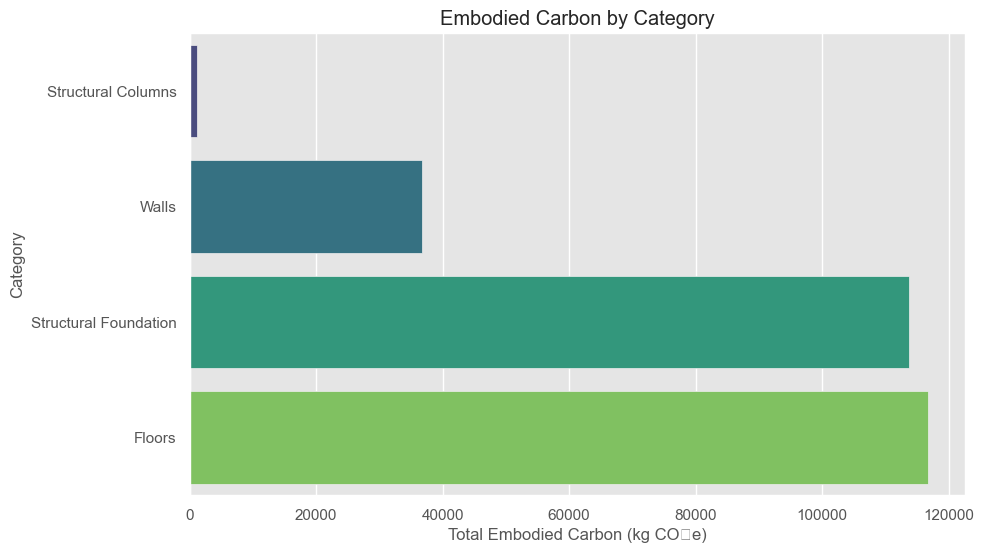

In [31]:
# Calculate total embodied carbon per category
carbon_by_category = df.groupby("category")["embodied_carbon"].sum().sort_values()

# Plot bar chart with updated 'hue' handling and font fixes
plt.figure(figsize=(10, 6))
sns.barplot(x=carbon_by_category, y=carbon_by_category.index, hue=carbon_by_category.index, palette="viridis")
plt.title("Embodied Carbon by Category")
plt.xlabel("Total Embodied Carbon (kg CO₂e)")
plt.ylabel("Category")

# Fix missing glyph warning by changing font to one that supports subscript characters
plt.rcParams["font.family"] = "DejaVu Sans"  # A font that supports subscript/superscript

plt.show()

Stacked Bar Chart: Embodied Carbon per Material for Each Level

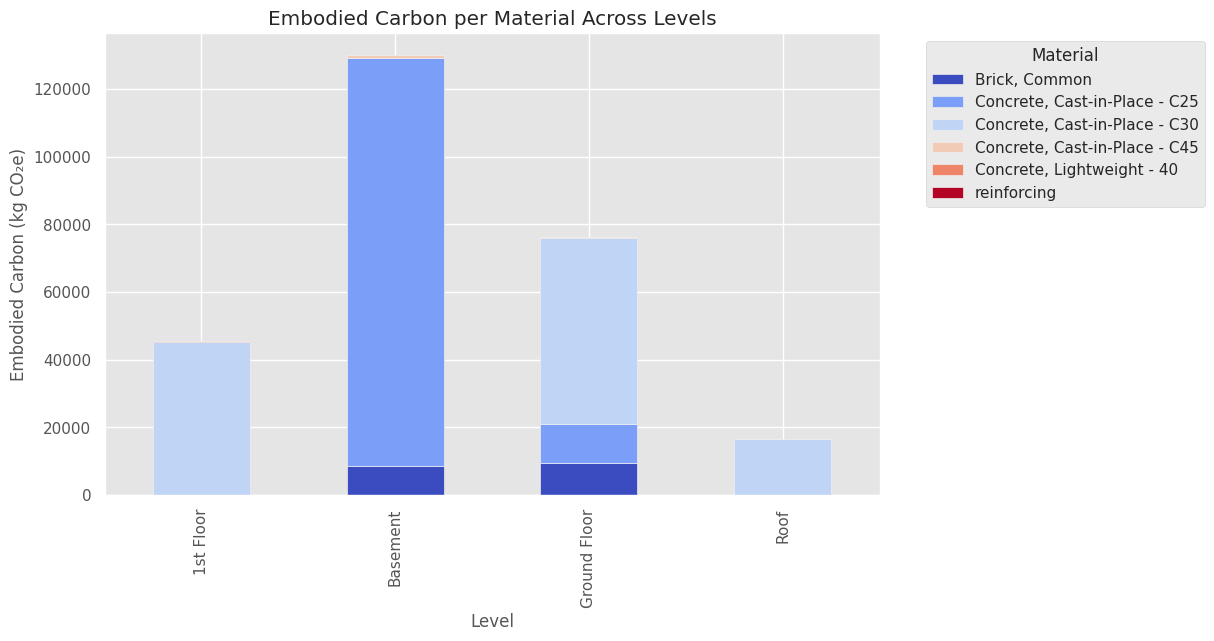

In [32]:
# Calculate total embodied carbon per material per level
carbon_material_level = df.groupby(["level", "material"])["embodied_carbon"].sum().unstack()

# Plot stacked bar chart
carbon_material_level.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(10, 6))
plt.title("Embodied Carbon per Material Across Levels")
plt.xlabel("Level")
plt.ylabel("Embodied Carbon (kg CO₂e)")
plt.legend(title="Material", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()
